# Africa Credit Challenge

The goals of this `starter notebook` are:

1. How to load data into a `Pandas` dataframe

2. How to `train` a basic machine learning model

3. How to `evaluate` the model

4. How to `save` your __submission__ following the required format.

<font color="red"><b>Note: This is just a starter notebook. It is by no means an ideal solution.</b></font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Load and Inspect the data

In [3]:
# Loading the train dataset
train = pd.read_csv('/content/drive/MyDrive/hackaton/african_credit_scoring/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/hackaton/african_credit_scoring/Test.csv')

#train = pd.read_csv('/content/drive/MyDrive/Hackaton/Train.csv')
#test = pd.read_csv('/content/drive/MyDrive/Hackaton/Test.csv')
# Display the first few rows of the datasets and their shape
#display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

In [4]:
train.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


In [5]:
indicators = pd.read_csv('/content/drive/MyDrive/hackaton/african_credit_scoring/economic_indicators.csv')

In [6]:
#indicators.head()

In [7]:
def format_indicators(indicators_df):
    """
    Formate le dataset des indicateurs pour être utilisé dans une jointure avec le dataset principal.

    Parameters:
        indicators_df (pd.DataFrame): Dataset brut contenant les indicateurs économiques.

    Returns:
        pd.DataFrame: Dataset formaté avec une colonne par indicateur et par année.
    """
    # Transformation des années en colonnes
    indicators_long = indicators_df.melt(
        id_vars=["Country", "Indicator"],
        var_name="Year",
        value_name="Value"
    )

    # Extraction de l'année depuis la colonne Year (YR suivi de l'année)
    indicators_long["Year"] = indicators_long["Year"].str.extract(r'(\d+)$').astype(int)

    # Pivot pour organiser les indicateurs en colonnes
    indicators_pivot = indicators_long.pivot_table(
        index=["Country", "Year"],
        columns="Indicator",
        values="Value"
    ).reset_index()

    # Nettoyage des noms de colonnes
    indicators_pivot.columns.name = None
    indicators_pivot = indicators_pivot.rename(columns=lambda x: x.lower().replace(" ", "_").replace(",", ""))

    return indicators_pivot


def enrich_dataset_with_indicators(loans_df, formatted_indicators_df):
    """
    Enrichit le dataset des prêts avec les indicateurs formatés.

    Parameters:
        loans_df (pd.DataFrame): Dataset principal contenant les informations sur les prêts.
        formatted_indicators_df (pd.DataFrame): Dataset formaté des indicateurs économiques.

    Returns:
        pd.DataFrame: Dataset enrichi avec les indicateurs correspondants.
    """
    # Ajouter une colonne pour l'année de déboursement extraite de `disbursement_date`
    loans_df["disbursement_year"] = pd.to_datetime(loans_df["disbursement_date"]).dt.year

    # Jointure avec le dataset des prêts sur la base du pays et de l'année
    enriched_df = loans_df.merge(
        formatted_indicators_df,
        how="left",
        left_on=["country_id", "disbursement_year"],
        right_on=["country", "year"]
    )

    # Suppression des colonnes inutiles après la jointure
    enriched_df = enriched_df.drop(columns=["country", "year", "disbursement_year"])
    # Identifier les colonnes ajoutées (colonnes d'indicateurs)
    new_columns = list(set(enriched_df.columns) - set(loans_df.columns))

    # Gérer les valeurs manquantes dans les nouvelles colonnes par imputation
    enriched_dataset = impute_missing_values_with_median(enriched_df, new_columns)


    return enriched_df

def impute_missing_values_with_median(df, columns_to_impute):
    """
    Impute les valeurs manquantes dans les colonnes spécifiées en utilisant la médiane.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        columns_to_impute (list): Liste des colonnes pour lesquelles imputer les valeurs manquantes.

    Returns:
        pd.DataFrame: Le DataFrame avec les valeurs manquantes imputées.
    """
    for column in columns_to_impute:
        if column in df.columns:
            # Calcul de la médiane de la colonne
            median_value = df[column].median()
            # Remplacement des NaN par la médiane
            df[column].fillna(median_value, inplace=True)
    return df


In [8]:
# Formater les indicateurs
formatted_indicators = format_indicators(indicators)
#formatted_indicators.head()

In [9]:
# Compter les valeurs manquantes pour chaque colonne
missing_counts = formatted_indicators.isna().sum()
threshold = 0
# Identifier les colonnes à conserver (en dessous du seuil de valeurs manquantes)
columns_to_keep  = missing_counts[missing_counts <= threshold].index
formatted_indicators = formatted_indicators[columns_to_keep]
formatted_indicators

,country,year,inflation_consumer_prices_(annual_%),official_exchange_rate_(lcu_per_us$_period_average),unemployment_rate
0,Cote d'Ivoire,2001,4.361529,732.397693,5.199
1,Cote d'Ivoire,2002,3.077265,693.713226,5.516
2,Cote d'Ivoire,2003,3.296807,579.897426,5.858
3,Cote d'Ivoire,2004,1.457988,527.338032,5.930
4,Cote d'Ivoire,2005,3.885830,527.258363,6.041
...,...,...,...,...,...
64,Kenya,2019,5.239638,101.991298,5.014
65,Kenya,2020,5.405162,106.450780,5.621
66,Kenya,2021,6.107936,109.637747,5.693
67,Kenya,2022,7.659863,117.865989,5.805


In [10]:
# Enrichir le dataset des prêts
train = enrich_dataset_with_indicators(train, formatted_indicators)
test = enrich_dataset_with_indicators(test, formatted_indicators)
train

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,inflation_consumer_prices_(annual_%),official_exchange_rate_(lcu_per_us$_period_average),unemployment_rate
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0,7.659863,117.865989,5.805
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0,7.659863,117.865989,5.805
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0,7.659863,117.865989,5.805
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0,7.659863,117.865989,5.805
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0,7.659863,117.865989,5.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,7,Repeat Loan,438.00,0.300000,455.0,0,7.659863,117.865989,5.805
68650,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,7,Repeat Loan,1508.70,0.300000,1535.0,0,7.659863,117.865989,5.805
68651,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,7,Repeat Loan,1586.70,0.300000,1587.0,0,7.659863,117.865989,5.805
68652,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,7,Repeat Loan,741.09,0.222283,741.0,0,7.659863,117.865989,5.805


In [11]:
# Check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   ID                                                   68654 non-null  object 
 1   customer_id                                          68654 non-null  int64  
 2   country_id                                           68654 non-null  object 
 3   tbl_loan_id                                          68654 non-null  int64  
 4   lender_id                                            68654 non-null  int64  
 5   loan_type                                            68654 non-null  object 
 6   Total_Amount                                         68654 non-null  float64
 7   Total_Amount_to_Repay                                68654 non-null  float64
 8   disbursement_date                                    68654 non-nul

In [12]:
# Are there missing values in the train dataset ?
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


In [13]:
# Find the last date in the 'activitydatetime' column
last_date = train['disbursement_date'].max()
first_date = train['disbursement_date'].min()
print("The most recent disbursement date is:", last_date)
print("The oldest disbursement_date is:", first_date)

The most recent disbursement date is: 2024-11-14
The oldest disbursement_date is: 2021-10-04


In [14]:
train

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,inflation_consumer_prices_(annual_%),official_exchange_rate_(lcu_per_us$_period_average),unemployment_rate
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0,7.659863,117.865989,5.805
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0,7.659863,117.865989,5.805
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0,7.659863,117.865989,5.805
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0,7.659863,117.865989,5.805
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0,7.659863,117.865989,5.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,7,Repeat Loan,438.00,0.300000,455.0,0,7.659863,117.865989,5.805
68650,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,7,Repeat Loan,1508.70,0.300000,1535.0,0,7.659863,117.865989,5.805
68651,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,7,Repeat Loan,1586.70,0.300000,1587.0,0,7.659863,117.865989,5.805
68652,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,7,Repeat Loan,741.09,0.222283,741.0,0,7.659863,117.865989,5.805


### EDA

In [15]:
def plot_continuous(df, column, transform=None):
    """
    Plots visualizations for a continuous variable, showing the distribution and boxplot for both
    the original and transformed versions of the data.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the continuous variable to plot.
        transform (str, optional): Transformation to apply to the data before plotting.
                                  Accepted values are 'log' or 'sqrt'. Default is None, which means no transformation.

    This function generates:
        - A histogram with a kernel density estimate (KDE) for the original data.
        - A boxplot for the original data.
        - If a transformation is specified ('log' or 'sqrt'):
            - A histogram with a KDE for the transformed data.
            - A boxplot for the transformed data.
    """
    # Create subplots for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Original data plots
    sns.histplot(df[column], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Distribution of {column}')
    axs[0, 0].set_xlabel(column)

    sns.boxplot(y=df[column], ax=axs[1, 0])
    axs[1, 0].set_title(f'Box Plot of {column}')
    axs[1, 0].set_ylabel(column)

    # Transformations (log or square root)
    if transform == 'log':
        transformed_data = np.log1p(df[column])  # log1p handles log(0) gracefully
        transform_label = 'Log'
    elif transform == 'sqrt':
        transformed_data = np.sqrt(df[column])  # Square root transformation
        transform_label = 'Square Root'
    else:
        transformed_data = None  # No transformation if not specified

    # If transformed data exists, generate corresponding plots
    if transformed_data is not None:
        sns.histplot(transformed_data, kde=True, ax=axs[0, 1])
        axs[0, 1].set_title(f'{transform_label} Distribution of {column}')
        axs[0, 1].set_xlabel(f'{transform_label}({column})')

        sns.boxplot(y=transformed_data, ax=axs[1, 1])
        axs[1, 1].set_title(f'{transform_label} Box Plot of {column}')
        axs[1, 1].set_ylabel(f'{transform_label}({column})')
    else:
        # If no transformation, remove the second set of axes
        for ax in [axs[0, 1], axs[1, 1]]:
            ax.remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


def plot_categorical(df, column):
    """
    Plots visualizations for a categorical variable, including a bar plot and a pie chart.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the categorical variable to plot.

    This function generates:
        - A bar plot showing the counts of each category in the specified column.
        - A pie chart showing the relative proportions of each category.
    """
    # Create subplots for visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Bar plot showing counts of each category
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax1)
    ax1.set_title(f'Bar Plot of {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Pie chart showing percentage distribution of each category
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax2.set_title(f'Pie Chart of {column}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


#### Categorical exploration

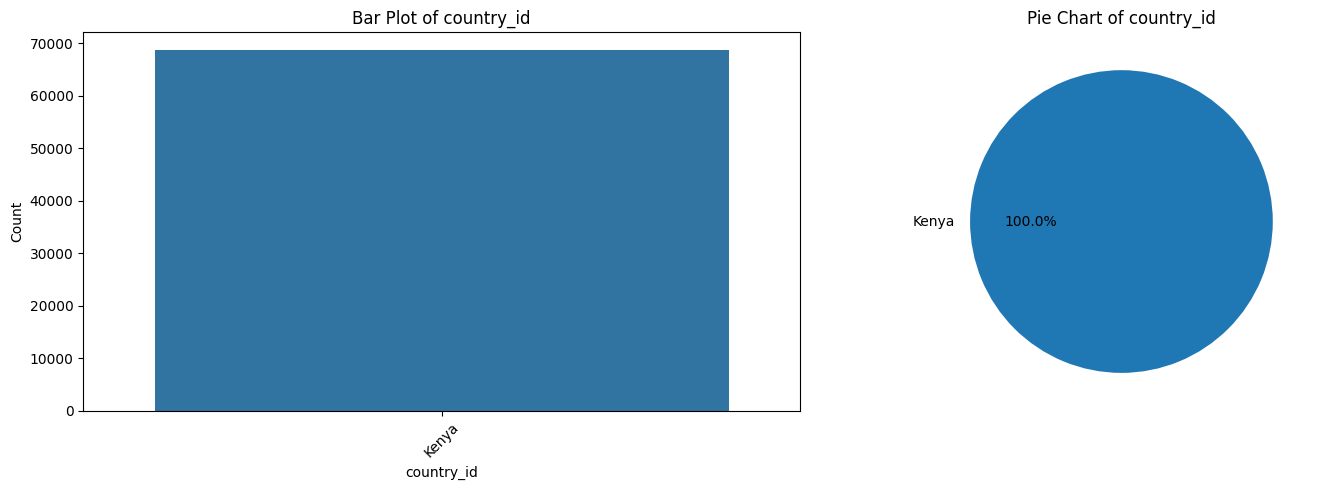

In [16]:
plot_categorical(train, 'country_id')

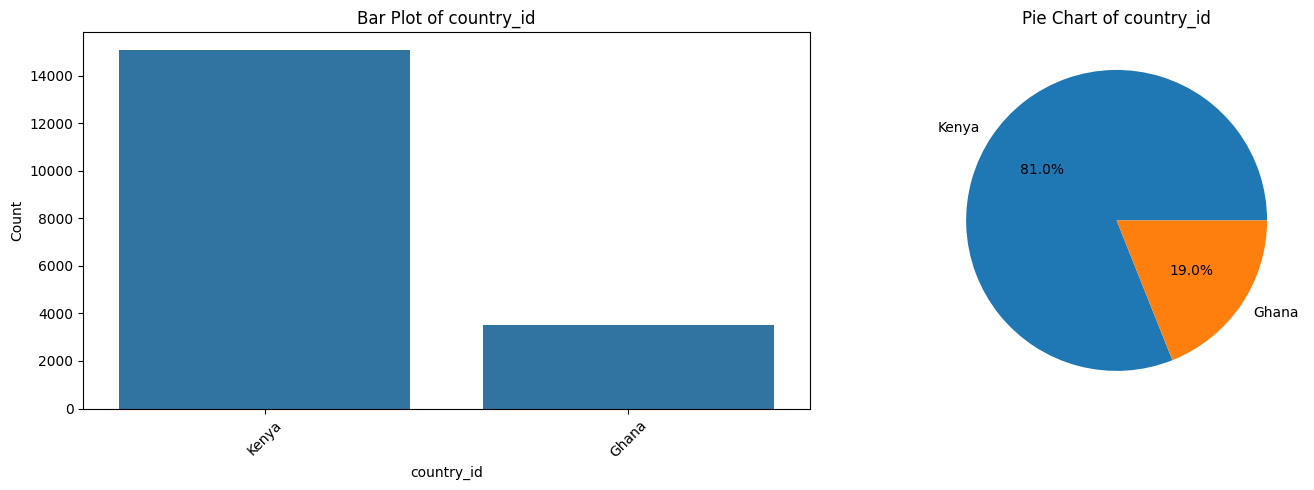

In [17]:
plot_categorical(test, 'country_id')

##### This shows that test has a new country, ghana so one of the goals is to build a solution that can generalize well in new regions

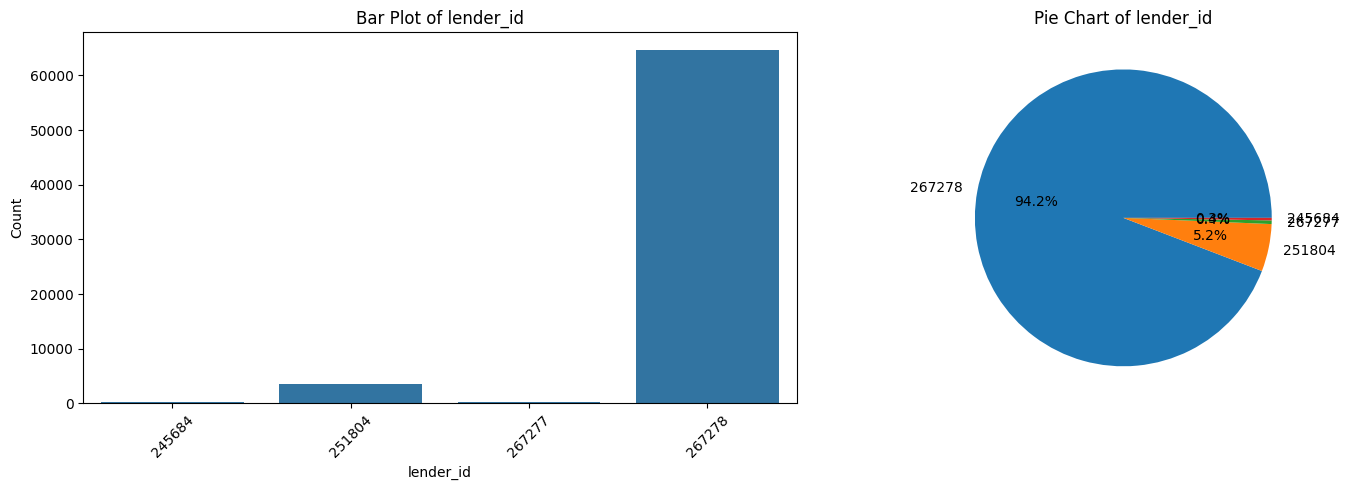

In [18]:
plot_categorical(train, 'lender_id')

##### You can exploree more of the categorical columns as well

#### TARGET EXPLORATION


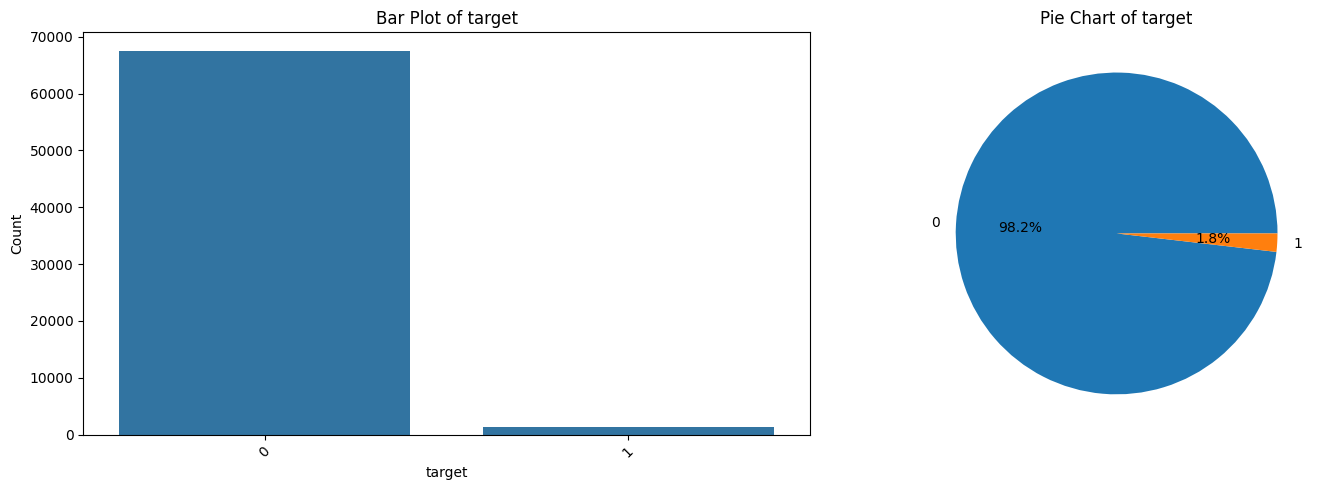

In [19]:
plot_categorical(train, 'target')

##### You can see the dataset is highly imbalanced , and this is expected in loan default scenarios, So find  ways to deal with the  imbalance

### CONTINUOUS COLUMN EXPLORATION

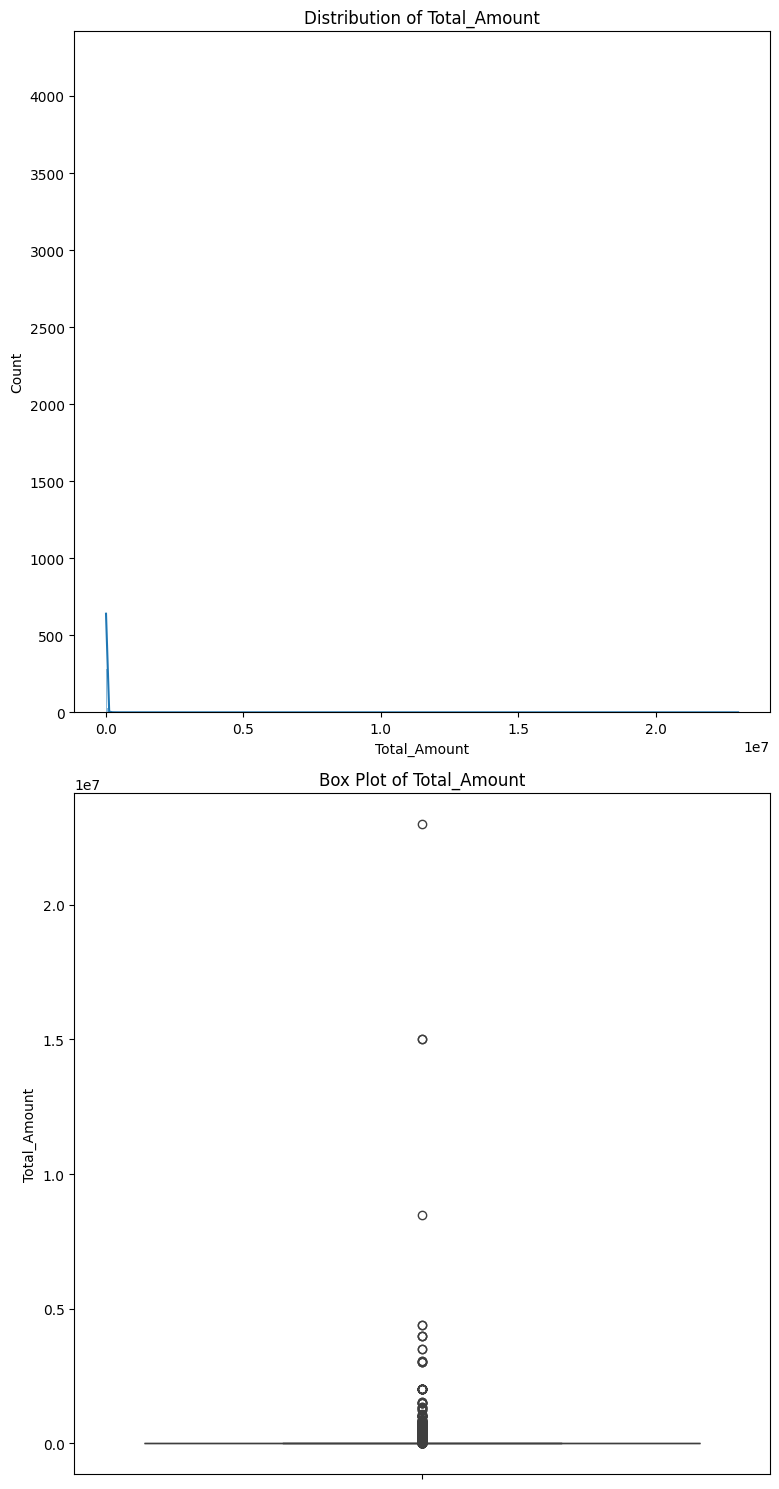

In [20]:
plot_continuous(train, 'Total_Amount')

Are those outliers?
##### You can explore more of the given numerical columns as well

In [21]:
#train.drop(columns=['Lender_portion_to_be_repaid', 'Total_Amount_to_Repay'], axis=1, inplace=True)
#test.drop(columns=['Lender_portion_to_be_repaid', 'Total_Amount_to_Repay'], axis=1, inplace=True)

### Feature Engineering
* So here we are going to concatenate both the train and test so that we can do the processing once instead of repeating for each

####Chargement Librairies

In [22]:
def treat_outliers_with_median(df, columns):
    """
    Traite les valeurs aberrantes dans les colonnes spécifiées en les remplaçant par la médiane.
    Les valeurs aberrantes sont détectées en utilisant la méthode de l'écart interquartile (IQR).

    :param df: DataFrame contenant les données
    :param columns: Liste des colonnes à traiter
    :return: DataFrame avec les valeurs aberrantes imputées
    """
    for column in columns:
        if column in df:
            # Calcul des percentiles et de l'IQR
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Calcul de la médiane
            median_value = df[column].mean()

            # Remplacer les valeurs aberrantes par la médiane
            df[column] = df[column].apply(
                lambda x: median_value if (x < lower_bound or x > upper_bound) else x
            )
    return df

def remove_outliers_with_listwise_deletion(df, columns):
    """
    Supprime les lignes contenant des valeurs aberrantes dans les colonnes spécifiées.
    Les valeurs aberrantes sont détectées en utilisant la méthode de l'écart interquartile (IQR).

    :param df: DataFrame contenant les données
    :param columns: Liste des colonnes à traiter
    :return: DataFrame sans les valeurs aberrantes
    """
    for column in columns:
        if column in df:
            # Calcul des percentiles et de l'IQR
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filtrer les lignes où les valeurs sont dans les limites acceptables
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Réinitialiser l'index après suppression
    df.reset_index(drop=True, inplace=True)
    return df


def calculate_prior_defaults(df):
    """
    Ajoute une colonne prior_defaulted_loan qui indique le nombre de fois qu'un client a eu un défaut de paiement
    avant la disbursement_date courante.

    :param df: DataFrame contenant les données des prêts
    :return: DataFrame avec une colonne prior_defaulted_loan ajoutée
    """
    # Assurez-vous que `disbursement_date` est au format datetime
    df['disbursement_date'] = pd.to_datetime(df['disbursement_date'])

    # Trier les données par customer_id et par disbursement_date
    df = df.sort_values(by=['customer_id', 'disbursement_date'])

    # Calculer le nombre de défauts avant chaque disbursement_date
    df['prior_defaulted_loan'] = (
        df.groupby('customer_id')['target']
        .apply(lambda x: x.cumsum().shift(fill_value=0))
        .reset_index(level=0, drop=True)  # Réinitialiser les index pour éviter les conflits
    )

    # S'assurer que les valeurs NaN (si existantes) sont initialisées à 0
    df['prior_defaulted_loan'] = df['prior_defaulted_loan'].fillna(0).astype(int)

    return df

def process_datetime_columns(df, date_cols):
    """
    Convertit les colonnes spécifiées en type datetime et extrait les informations de mois, jour, et année.

    :param df: DataFrame contenant les données
    :param date_cols: Liste des noms des colonnes de type datetime
    :return: DataFrame modifié avec des colonnes supplémentaires pour le mois, le jour et l'année
    """
    for col in date_cols:
        if col in df.columns:
            # Convertir en type datetime
            df[col] = pd.to_datetime(df[col], errors='coerce')

            # Extraire mois, jour et année
            df[col + '_month'] = df[col].dt.month
            df[col + '_day'] = df[col].dt.day
            df[col + '_year'] = df[col].dt.year

    return df

from sklearn.preprocessing import LabelEncoder
def process_categorical_columns(train_df, test_df, one_hot_cols, exclude_cols=[], target_col='target'):
    """
    Traite les colonnes catégoriques dans les datasets d'entraînement et de test en appliquant un encodage cohérent.
    Les datasets sont concaténés pour garantir la cohérence, puis re-séparés.

    :param train_df: DataFrame d'entraînement (contient une colonne cible `target_col`)
    :param test_df: DataFrame de test (ne contient pas `target_col`)
    :param one_hot_cols: Liste des colonnes à encoder avec one-hot encoding
    :param exclude_cols: Liste des colonnes à exclure du traitement
    :param target_col: Nom de la colonne cible dans le DataFrame d'entraînement
    :return: Tuple (train_df, test_df) avec colonnes catégoriques encodées
    """
    # Identifier et exclure la colonne cible `target` de train_df avant concaténation
    train_target = train_df[target_col]
    train_df = train_df.drop(columns=[target_col])
    #print(train_df.isna().sum())

    # Ajouter une colonne pour identifier les ensembles
    train_df['is_train'] = 1
    test_df['is_train'] = 0

    # Concaténer les datasets
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # Identifier toutes les colonnes catégoriques
    cat_cols = combined_df.select_dtypes(include='object').columns
    cat_cols = [col for col in cat_cols if col not in exclude_cols]

    # Appliquer le one-hot encoding aux colonnes spécifiées
    combined_df = pd.get_dummies(combined_df, columns=one_hot_cols, prefix=one_hot_cols, drop_first=False)

    # Remplacer les valeurs NaN par 0 pour éviter les erreurs de conversion
    one_hot_encoded_cols = [col for col in combined_df.columns if any(col.startswith(prefix + '_') for prefix in one_hot_cols)]
    combined_df[one_hot_encoded_cols] = combined_df[one_hot_encoded_cols].astype(int)

    # Appliquer le label encoding aux colonnes catégoriques restantes
    le = LabelEncoder()
    for col in [col for col in cat_cols if col not in one_hot_cols]:
        combined_df[col] = combined_df[col].fillna('Unknown')  # Remplir les NaN avec une catégorie par défaut
        combined_df[col] = le.fit_transform(combined_df[col])

    # Séparer à nouveau les datasets d'entraînement et de test
    train_df = combined_df[combined_df['is_train'] == 1].drop(columns=['is_train'])
    test_df = combined_df[combined_df['is_train'] == 0].drop(columns=['is_train'])

    # Réintégrer la colonne cible `target` dans train_df
    train_df[target_col] = train_target.values

    return train_df, test_df

###Traitement

In [23]:
date_cols = ['disbursement_date', 'due_date']
train = remove_outliers_with_listwise_deletion(train.copy(), ['Total_Amount','Amount_Funded_By_Lender'])

train_df = process_datetime_columns(train.copy(), date_cols)
test_df = process_datetime_columns(test.copy(), date_cols)

exclude_cols = ['ID', 'loan_type']  # Exclure l'ID et les colonnes déjà traitées pour le one-hot
one_hot_cols = ['loan_type']  # Colonne à encoder en one-hot
train_df, test_df = process_categorical_columns(train_df, test_df, one_hot_cols, exclude_cols)
#test_df = process_categorical_columns(test_df, one_hot_cols, exclude_cols)

In [24]:
### TRAIN
train_df['fee_and_interest'] = train_df['Total_Amount_to_Repay'].sub(train_df['Total_Amount'], fill_value=0)
train_df['Funded_Ratio'] = train_df['Amount_Funded_By_Lender'] / train_df['Total_Amount']
# deal with numerical columns: we saw loan amount is highly right skewed for this we can log transform it
train_df['Total_Amount'] = np.log1p(train_df['Total_Amount'])
#train_df['fee_and_interest'] = np.log1p(train_df['fee_and_interest']) # Génére des valeurs nuls
#process outlier

### TEST
test_df['fee_and_interest'] = test_df['Total_Amount_to_Repay'].sub(test_df['Total_Amount'], fill_value=0)
# deal with numerical columns: we saw loan amount is highly right skewed for this we can log transform it
test_df['Funded_Ratio'] = test_df['Amount_Funded_By_Lender'] / test_df['Total_Amount']
test_df['Total_Amount'] = np.log1p(test_df['Total_Amount'])
#test_df['fee_and_interest'] = np.log1p(test_df['fee_and_interest'])
#process outlier

In [25]:
#train_df = calculate_prior_defaults(train_df.copy())
#test_df = calculate_prior_defaults(test_df.copy())

In [26]:
# we are also going to drop the country id as we saw we have only one country in tra
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'cus', 'tbl_loan_id','Lender_portion_to_be_repaid', 'Total_Amount_to_Repay']]

# Check if the new datasets have the same rows as train and test datasets
print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")

The shape of train_df is: (58082, 49)
The shape of test_df is: (18594, 48)
The shape of train is: (58082, 19)
The shape of test is: (18594, 18)
The features for modelling are:
['customer_id', 'country_id', 'lender_id', 'Total_Amount', 'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'inflation_consumer_prices_(annual_%)', 'official_exchange_rate_(lcu_per_us$_period_average)', 'unemployment_rate', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'due_date_month', 'due_date_day', 'due_date_year', 'loan_type_Type_1', 'loan_type_Type_10', 'loan_type_Type_11', 'loan_type_Type_12', 'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_15', 'loan_type_Type_16', 'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_2', 'loan_type_Type_20', 'loan_type_Type_21', 'loan_type_Type_22', 'loan_type_Type_23', 'loan_type_Type_24', 'loan_type_Type_3', 'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6', 'loan_type_Type_7', '

In [27]:
train

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,inflation_consumer_prices_(annual_%),official_exchange_rate_(lcu_per_us$_period_average),unemployment_rate
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0,7.659863,117.865989,5.805
1,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0,7.659863,117.865989,5.805
2,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0,7.659863,117.865989,5.805
3,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0,7.659863,117.865989,5.805
4,ID_265607284433267278,265607,Kenya,284433,267278,Type_1,4325.0,4325.0,2022-10-19,2022-10-26,7,Repeat Loan,1297.50,0.300000,1298.0,0,7.659863,117.865989,5.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58077,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,7,Repeat Loan,438.00,0.300000,455.0,0,7.659863,117.865989,5.805
58078,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,7,Repeat Loan,1508.70,0.300000,1535.0,0,7.659863,117.865989,5.805
58079,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,7,Repeat Loan,1586.70,0.300000,1587.0,0,7.659863,117.865989,5.805
58080,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,7,Repeat Loan,741.09,0.222283,741.0,0,7.659863,117.865989,5.805


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58082 entries, 0 to 58081
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   ID                                                   58082 non-null  object 
 1   customer_id                                          58082 non-null  int64  
 2   country_id                                           58082 non-null  object 
 3   tbl_loan_id                                          58082 non-null  int64  
 4   lender_id                                            58082 non-null  int64  
 5   loan_type                                            58082 non-null  object 
 6   Total_Amount                                         58082 non-null  float64
 7   Total_Amount_to_Repay                                58082 non-null  float64
 8   disbursement_date                                    58082 non-nul

### CROSS VALIDATION
* Here we are going to use a simple train test split but due to the imbalance try other robust methods like StratifiedKFold


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=0)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(43561, 42) (14521, 42) (43561,) (14521,)


In [30]:
print(f"nombre de no loan(0) et loan(1) dans y_train\n", y_train.value_counts())

nombre de no loan(0) et loan(1) dans y_train
 target
0    42943
1      618
Name: count, dtype: int64


In [31]:
!pip install imblearn

In [32]:
#Load our local fonctions
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Initialiser et appliquer SMOTE avec un ratio de 0.3
smot = SMOTE(sampling_strategy=0.3, random_state=0)
X_train, y_train = smot.fit_resample(X_train, y_train)

In [33]:
from imblearn.under_sampling import ClusterCentroids

# Initialiser ClusterCentroids avec un ratio de 0.33
#cluster_centroids = ClusterCentroids(sampling_strategy=0.4, random_state=0)
#X_train, y_train = cluster_centroids.fit_resample(X_train, y_train)

In [34]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## Initialisation & Model Training

###Chargement librairies

In [35]:
def plot_boxplot_of_probabilities(model, X_test, y_test, y_test_prob, title, threshold=0.5):
    """
    Trace une boîte à moustaches des probabilités prédites pour les faux positifs et les faux négatifs.

    Parameters:
    - model : le modèle de machine learning
    - X_test : les caractéristiques de test
    - y_test : les étiquettes de test
    - y_test_prob : les probabilités prédites pour les étiquettes de test
    - threshold : le seuil pour déterminer les prédictions positives (par défaut à 0.5)
    """
    # Conversion de y_test en série si ce n'est pas déjà le cas
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.squeeze()
    elif isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)

    # Vérifier que y_test_prob est de la même longueur que y_test
    if len(y_test) != len(y_test_prob):
        raise ValueError("La longueur de y_test_prob doit être égale à celle de y_test")

    # Détermination des faux positifs et faux négatifs
    fp_probs = y_test_prob[(y_test_prob >= threshold) & (y_test == 0)]
    fn_probs = y_test_prob[(y_test_prob <= threshold) & (y_test == 1)]

    # Création de la boîte à moustaches
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[fp_probs, fn_probs], notch=True, palette=['red', 'blue'])
    plt.xticks([0, 1], ['Faux Positifs', 'Faux Négatifs'])
    plt.ylabel('Probabilités Prédites')
    plt.title(title) #'Distribution des probabilités pour les Faux Positifs et Faux Négatifs'
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Tracer la courbe ROC pour les prédictions de probabilité d'un modèle.

    Parameters:
    - y_true : array, vrai labels des données de test.
    - y_pred_proba : array, probabilités prédites de la classe positive par le modèle.
    - model_name : str, le nom du modèle pour afficher dans le titre du graphique.

    Returns:
    - Aucun, affiche un graphique.
    """
    # Calcul des taux pour la courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Tracé de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score, accuracy_score, precision_score, f1_score
def evaluate_tree_ensemble_model(model, X_train, y_train, X_test, y_test, y_train_proba, y_test_proba, threshold=0.5):
    """
    Evaluate the tree ensemble model by calculating performance metrics and displaying both confusion matrices and a table of metrics.

    Args:
        model: Trained tree ensemble model (e.g., RandomForest, XGBoost).
        X_train, y_train: Training data and labels.
        X_test, y_test: Testing data and labels.
        threshold: Probability threshold to determine class labels.
    """
    # Convert probabilities to binary predictions based on the threshold
    y_train_pred = (y_train_proba >= threshold).astype(int)
    y_test_pred = (y_test_proba >= threshold).astype(int)

    # Display confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_train, annot=True, fmt="d", ax=ax[0], cmap="Blues")
    ax[0].set_title("Confusion Matrix (Train)")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")
    sns.heatmap(cm_test, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title("Confusion Matrix (Test)")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")
    plt.show()

    # Calculate metrics
    metrics = {
        'Metric': ['Recall', 'AUC', 'Accuracy', 'Precision', 'F1 Score'],
        'Train': [
            recall_score(y_train, y_train_pred),
            roc_auc_score(y_train, y_train_proba),
            accuracy_score(y_train, y_train_pred),
            precision_score(y_train, y_train_pred),
            f1_score(y_train, y_train_pred)
        ],
        'Test': [
            recall_score(y_test, y_test_pred),
            roc_auc_score(y_test, y_test_proba),
            accuracy_score(y_test, y_test_pred),
            precision_score(y_test, y_test_pred),
            f1_score(y_test, y_test_pred)
        ]
    }

    # Create and print a DataFrame for displaying metrics
    results_df = pd.DataFrame(metrics)
    print(results_df.set_index('Metric'))
    return results_df

def plot_confidence_histogram(model, X_test, y_test, y_test_prob, title, threshold=0.5):
    """
    Trace un histogramme de confiance des probabilités prédites pour les faux positifs et les faux négatifs.

    Parameters:
    - model : le modèle de machine learning
    - X_test : les caractéristiques de test
    - y_test : les étiquettes de test
    - y_test_prob : les probabilités prédites pour les étiquettes de test
    - threshold : le seuil pour déterminer les prédictions positives (par défaut à 0.5)
    """
    # Conversion de y_test en série si ce n'est pas déjà le cas
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.squeeze()
    elif isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)

    # Vérifier que y_test_prob est de la même longueur que y_test
    if len(y_test) != len(y_test_prob):
        raise ValueError("La longueur de y_test_prob doit être égale à celle de y_test")

    # Détermination des faux positifs et faux négatifs
    fp_probs = y_test_prob[(y_test_prob >= threshold) & (y_test == 0)]
    fn_probs = y_test_prob[(y_test_prob <= threshold) & (y_test == 1)]

    # Création de l'histogramme
    plt.figure(figsize=(12, 8))
    plt.hist(fp_probs, bins=30, alpha=0.5, label='Faux Positifs', color='red')
    plt.hist(fn_probs, bins=30, alpha=0.5, label='Faux Négatifs', color='blue')
    plt.xlabel('Probabilité prédite')
    plt.ylabel('Nombre d\'observations')
    plt.title(title)#Histogramme de Confiance des Prédictions
    plt.xlim(0, 1)
    plt.legend()
    plt.show()


def plot_feature_importances(model, feature_names, title, top_n=16):
    """
    Plot the top n feature importances of the given model.

    Args:
        model: The trained model, e.g., an instance of RandomForestClassifier or RandomForestRegressor.
        feature_names (list): A list of names corresponding to the features in the training data.
        top_n (int): The number of top features to display.
    """
    # Extract feature importances from the model
    importances = model.feature_importances_

    # Create a DataFrame for easier handling
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Select top n features
    feature_importances = feature_importances.head(top_n)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances)

    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
def evaluate_model(model, X_train, y_train, X_test, y_test, y_test_proba, y_train_proba, y_test_pred, y_train_pred):
    """
    Evaluate the model by calculating performance metrics with a custom threshold for classification.

    Args:
        model: Trained Keras model.
        X_train, y_train: Training data and labels.
        X_test, y_test: Testing data and labels.
        threshold (float): Threshold to convert probabilities to binary outputs.
    """

    # Confusion matrices for the train and test sets
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Display confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_train, annot=True, fmt="d", ax=ax[0], cmap="Blues")
    ax[0].set_title("Confusion Matrix (Train)")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")

    sns.heatmap(cm_test, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title("Confusion Matrix (Test)")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")
    plt.show()
    # Calculate metrics
    metrics = {
        'Metric': ['Recall', 'AUC', 'Accuracy', 'Precision', 'F1 Score'],
        'Train': [
            recall_score(y_train, y_train_pred),
            roc_auc_score(y_train, y_train_proba),
            accuracy_score(y_train, y_train_pred),
            precision_score(y_train, y_train_pred),
            f1_score(y_train, y_train_pred)
        ],
        'Test': [
            recall_score(y_test, y_test_pred),
            roc_auc_score(y_test, y_test_proba),
            accuracy_score(y_test, y_test_pred),
            precision_score(y_test, y_test_pred),
            f1_score(y_test, y_test_pred)
        ]
    }

    # Create a DataFrame for displaying
    results_df = pd.DataFrame(metrics)
    print(results_df.set_index('Metric'))
    return results_df

### XGBoost

In [36]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# Définition de la grille d'hyperparamètres
param_grid = {
    'n_estimators': [1000, 1500],
    'max_depth': [15, 25, 30],
    'min_child_weight': [2, 4, 6],
    'gamma': [0.2, 0.3],
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.4, 0.5],
    'reg_alpha': [0.1, 0.2, 0.4],
    'reg_lambda': [0.2, 0.4],
    'learning_rate': [0.05, 0.1],
    'smot__sampling_strategy' : [0.2, 0.3]
}


In [38]:
total_classes = y_train.value_counts()
nombre_total_de_classes_positives = total_classes[1]  # Classe positive (supposons que c'est la classe 1)
nombre_total_de_classes_negatives = total_classes[0]  # Classe négative (supposons que c'est la classe 0)
scale_pos_weight = (nombre_total_de_classes_negatives) / (nombre_total_de_classes_positives)

In [39]:
!pip install scikit-learn==1.4 #Downgrading scikit-learn to a compatible version
!pip install --upgrade xgboost

  Using cached scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


ERROR: Operation cancelled by user


In [ ]:
# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        n_jobs=-1,
        random_state=0
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=10,
    verbose=2,
    n_jobs=-1
)

# Exécution de la recherche en grille
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres trouvés : ", grid_search.best_params_)

Fitting 10 folds for each of 3456 candidates, totalling 34560 fits


In [ ]:
# Récupération du meilleur modèle
xgb_model = grid_search.best_estimator_

In [ ]:
import joblib
joblib.dump(xgb_model, 'xgb_model_v1_6.joblib')
print("Modèle enregistré avec succès.")

In [32]:
y_valid_proba_xgb = xgb_model.predict_proba(X_valid)[:, 1]
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]

In [33]:
threshold = 0.5
title_xgb  = "XGBoost"

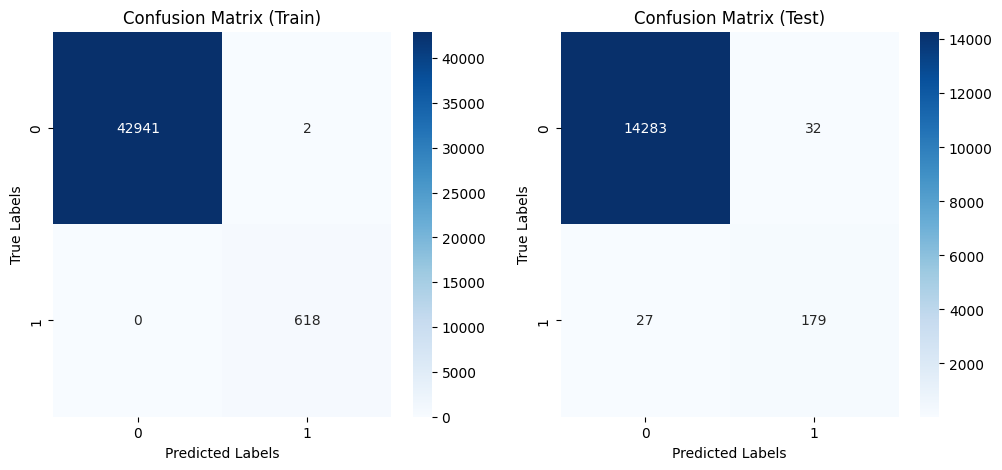

              Train      Test
Metric                       
Recall     1.000000  0.868932
AUC        1.000000  0.985814
Accuracy   0.999954  0.995937
Precision  0.996774  0.848341
F1 Score   0.998384  0.858513


In [34]:
resultat_xgb = evaluate_tree_ensemble_model(xgb_model, X_train, y_train, X_valid, y_valid, y_train_proba_xgb, y_valid_proba_xgb)

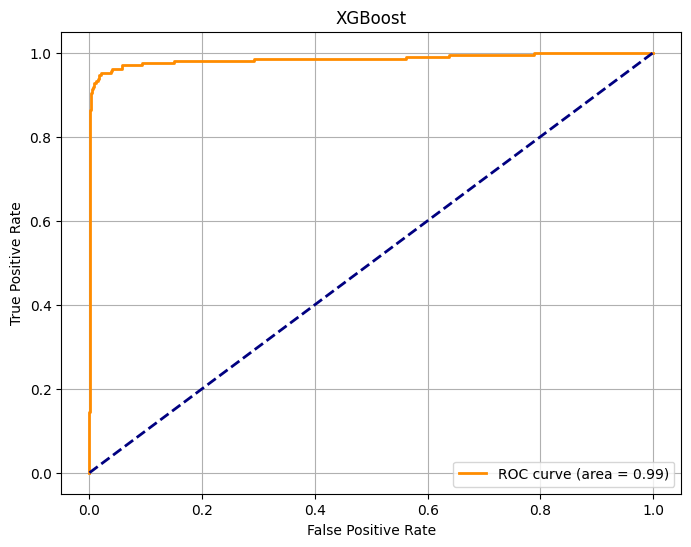

In [35]:
plot_roc_curve(y_valid, y_valid_proba_xgb, model_name=title_xgb)

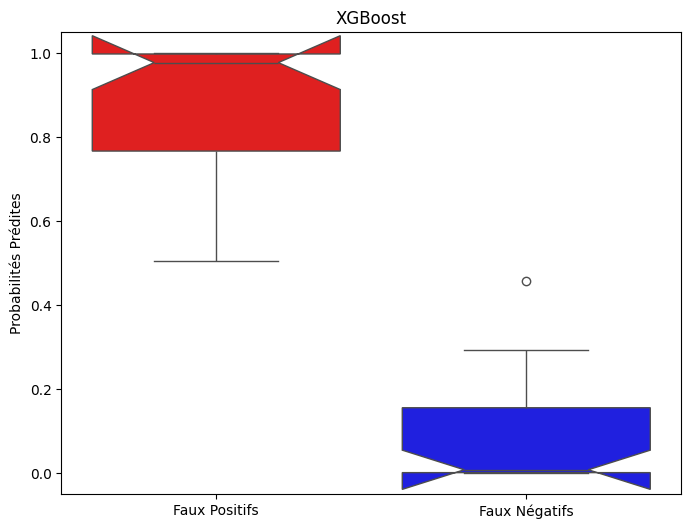

In [36]:
plot_boxplot_of_probabilities(xgb_model, X_valid, y_valid, y_valid_proba_xgb, title_xgb)

In [37]:
feature_names = X_train.columns
feature_names = feature_names.tolist()
#feature_names

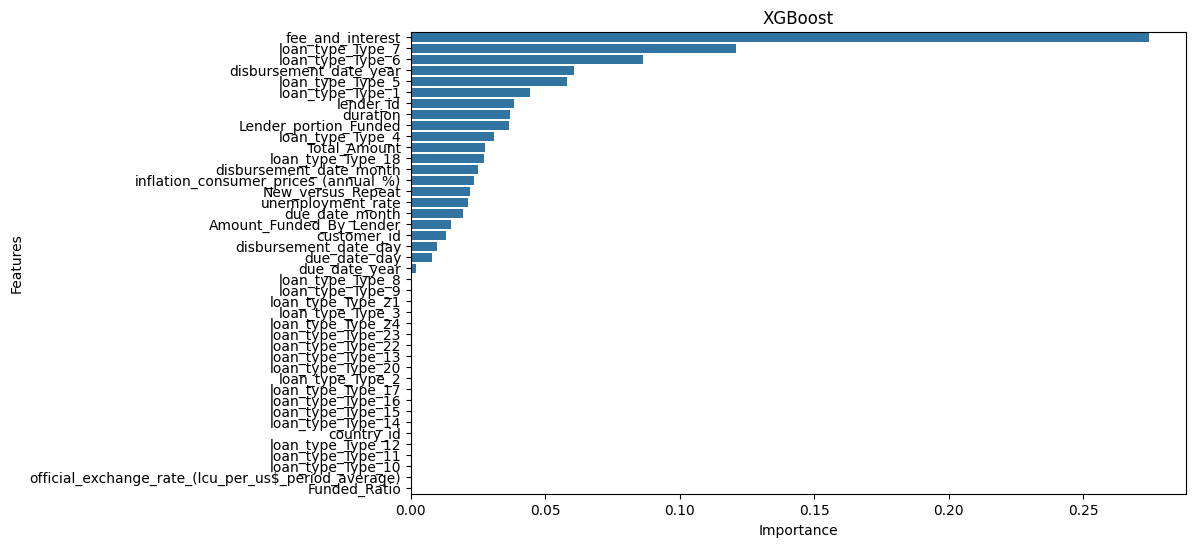

In [38]:
plot_feature_importances(xgb_model, feature_names,title_xgb,len(feature_names))

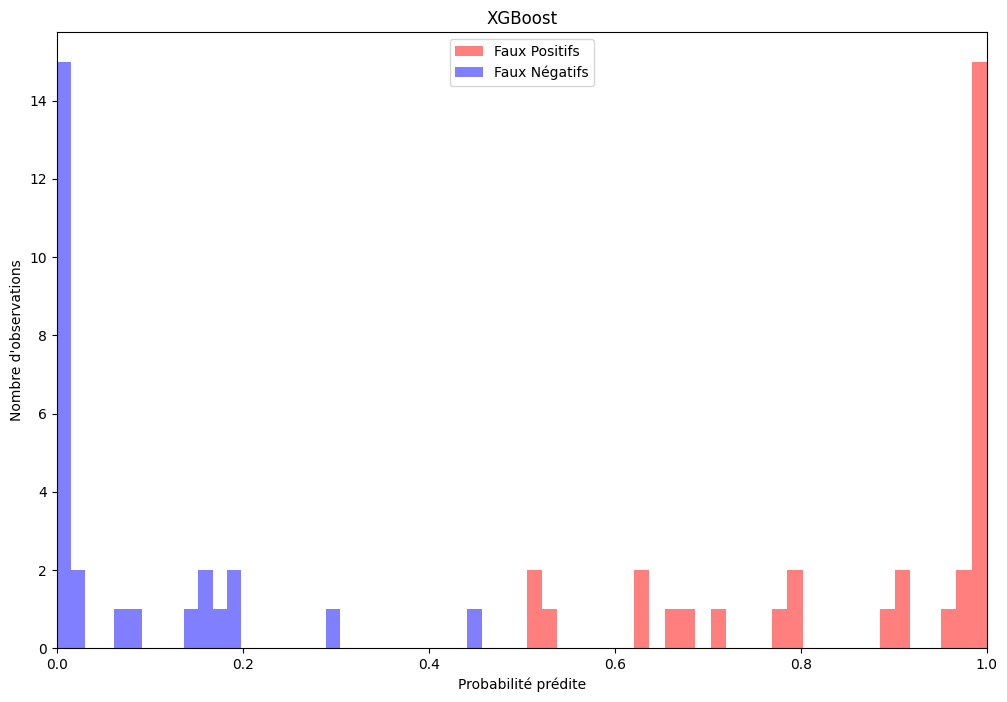

In [39]:
plot_confidence_histogram(xgb_model, X_valid, y_valid, y_valid_proba_xgb, title_xgb)

### RAndom Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Définition de la grille d'hyperparamètres
param_grid = {
    'n_estimators': [500],  # Nombre d'arbres
    'max_depth': [20, 30, 50],   # Profondeur maximale des arbres
    'min_samples_split': [2, 4],  # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [2, 4],   # Nombre minimum d'échantillons requis à un nœud feuille
    'max_features': ['sqrt'],     # Nombre de caractéristiques à considérer lors de la recherche de la meilleure division
    'class_weight': ['balanced']  # Équilibrage des classes
}


In [37]:
# Création de l'objet GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, verbose=True, random_state=0),
    param_grid=param_grid,
    scoring='f1',
    cv=10,
    verbose=2,
    n_jobs=-1
)

# Exécution de la recherche en grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres trouvés : ", grid_search.best_params_)
# Get the best parameters and the best model
best_params = grid_search.best_params_
rf_model = grid_search.best_estimator_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   28.2s


Meilleurs hyperparamètres trouvés :  {'class_weight': 'balanced', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.9s finished


In [38]:
threshold = 0.5
title = "Random Forest"

In [39]:
joblib.dump(rf_model, 'rf_model_3_0.joblib')
print("Modèle enregistré avec succès.")

NameError: name 'joblib' is not defined

In [ ]:
y_valid_proba = rf_model.predict_proba(X_valid)[:, 1]
y_train_proba = rf_model.predict_proba(X_train)[:, 1]

In [ ]:
resultat_rf = evaluate_tree_ensemble_model(rf_model, X_train, y_train, X_valid, y_valid, y_train_proba, y_valid_proba, threshold=0.5)

In [ ]:
t

In [ ]:
# Make predictions on the test dataset
test_predictions = rf_model.predict(test_df[features_for_modelling])
test_predictions_proba = rf_model.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file

test_df['target'] = test_predictions
sub =  test_df[['ID', 'target']]
sub.head()


Evaluation

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# Définir le modèle AdaBoost
ada_model = AdaBoostClassifier(random_state=0)
# Définir les hyperparamètres à explorer
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.05, 0.1],
}
# Configurer la recherche en grille
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, scoring='f1', cv=10, n_jobs=-1, verbose=2)

# Ajuster le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Meilleur modèle ajusté
best_ada_model = grid_search.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 300}


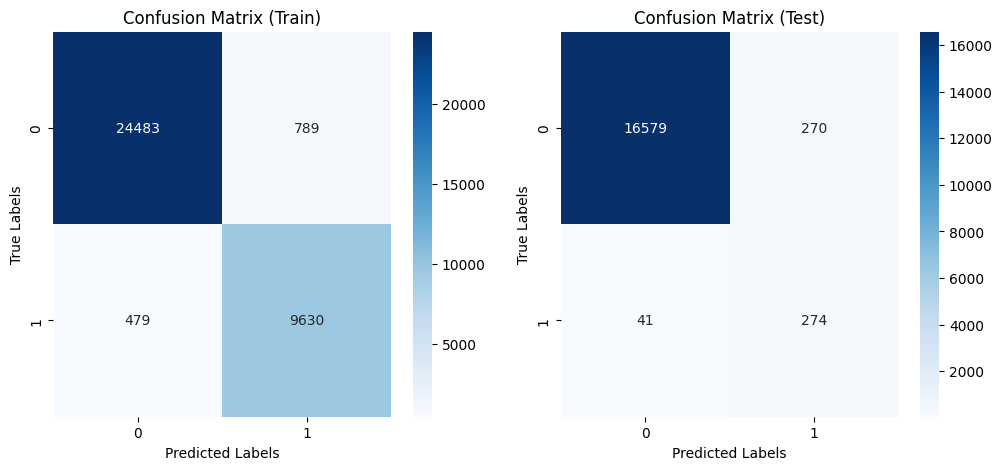

              Train      Test
Metric                       
Recall     0.952616  0.869841
AUC        0.992798  0.988778
Accuracy   0.964162  0.981881
Precision  0.924273  0.503676
F1 Score   0.938231  0.637951


In [ ]:
y_test_proba_ada = best_ada_model.predict_proba(X_valid)[:, 1]
y_train_proba_ada = best_ada_model.predict_proba(X_train)[:, 1]
threshold = 0.5
y_train_pred_ada = (y_train_proba_ada >= threshold).astype(int)
y_test_pred_ada = (y_test_proba_ada >= threshold).astype(int)
resultat_ada = evaluate_tree_ensemble_model(best_ada_model, X_train, y_train, X_valid, y_valid, y_train_proba_ada, y_test_proba_ada, threshold=0.5)

### ANN

In [ ]:
X_train

,customer_id,country_id,lender_id,Total_Amount,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,disbursement_date_month,disbursement_date_day,...,loan_type_Type_23,loan_type_Type_24,loan_type_Type_3,loan_type_Type_4,loan_type_Type_5,loan_type_Type_6,loan_type_Type_7,loan_type_Type_8,loan_type_Type_9,fee_and_interest
0,251137,1,267278,9.419223,7,1,969.570000,0.078686,8,18,...,0,0,0,0,0,0,0,0,0,0.000000
1,259244,1,267278,7.919356,7,1,824.700000,0.300000,7,25,...,0,0,0,0,0,0,0,0,0,0.000000
2,243264,1,267278,8.578288,7,1,1594.200000,0.300000,9,9,...,0,0,0,0,0,0,0,0,0,93.000000
3,254014,1,267278,9.093807,7,1,454.740000,0.051100,9,27,...,0,0,0,0,0,0,0,0,0,0.000000
4,115025,1,267278,9.314520,7,1,3329.100000,0.300000,11,2,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65706,20223,1,254997,9.983301,12,1,2875.818573,0.133519,3,9,...,0,0,0,0,0,0,0,0,0,3814.919493
65707,261731,1,267278,7.973879,7,1,835.940337,0.292512,7,29,...,0,0,0,0,0,0,0,0,0,684.018530
65708,241007,1,267278,7.523474,7,0,559.343895,0.300000,7,21,...,0,0,0,0,0,0,0,0,0,538.407682
65709,309946,1,267278,8.515615,7,1,998.027122,0.199944,9,30,...,0,0,0,0,0,0,1,0,0,333.848471


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold

# Définir le modèle MLP
def build_mlp_model(input_shape):
    ann_model = Sequential([
        Dense(128, input_shape=(input_shape,), activation='relu'),
        Dropout(0.2),
        Dense(64, input_shape=(input_shape,), activation='relu'),
        Dropout(0.2),
        Dense(32, input_shape=(input_shape,), activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    ann_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return ann_model

input_shape = X_train_scaled.shape[1]

ann_model = build_mlp_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min')

# Entraînement du modèle avec des poids de classe
history = ann_model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid),
                    epochs=200, batch_size=32,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/200
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4742 - precision_4: 0.5857 - recall_4: 0.7005 - val_loss: 0.2886 - val_precision_4: 0.1054 - val_recall_4: 0.7746 - learning_rate: 0.0010
Epoch 2/200
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2767 - precision_4: 0.7073 - recall_4: 0.8954 - val_loss: 0.1558 - val_precision_4: 0.1719 - val_recall_4: 0.8190 - learning_rate: 0.0010
Epoch 3/200
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1894 - precision_4: 0.7741 - recall_4: 0.9433 - val_loss: 0.1639 - val_precision_4: 0.1763 - val_recall_4: 0.8889 - learning_rate: 0.0010
Epoch 4/200
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1642 - precision_4: 0.7805 - recall_4: 0.9566 - val_loss: 0.1130 - val_precision_4: 0.2182 - val_recall_4: 0.8063 - learning_rate: 0.0010
Epoch 5/200
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1505 - precision_4: 0.7953 - recall_4: 0.9575 - val_loss: 0.1269 - val_precision_4: 0.1897 - val_recall_4: 0.8571 - lear

In [ ]:
#  save model
model.save('ann_model_v.keras')
print("Modèle enregistré avec succès.")

In [ ]:
# Get probabilities for the positive class
y_valid_proba_ann = ann_model.predict(X_valid)[:, 0]
y_train_proba_ann = ann_model.predict(X_train)[:, 0]
threshold=0.7
# Apply threshold to convert probabilities to binary classification
y_valid_pred_ann = (y_valid_proba_ann >= threshold).astype(int)
y_train_pred_ann = (y_train_proba_ann >= threshold).astype(int)

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


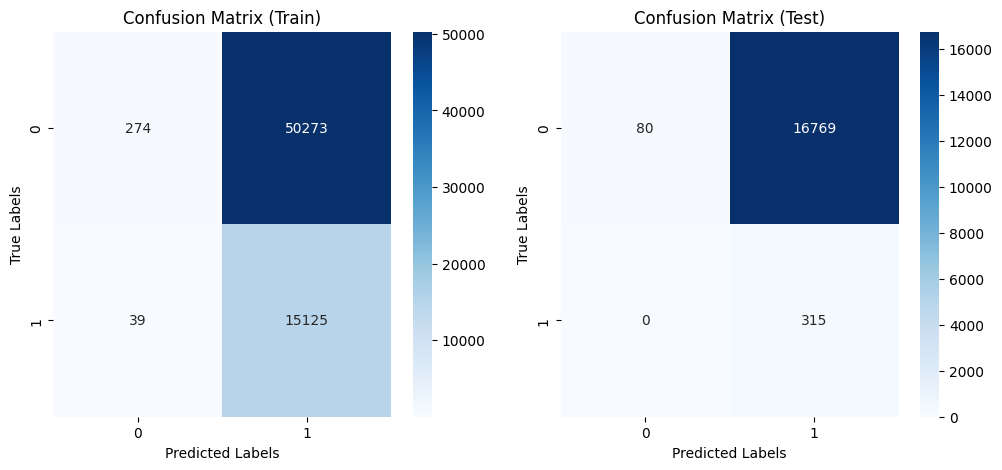

              Train      Test
Metric                       
Recall     0.997428  1.000000
AUC        0.501425  0.502374
Accuracy   0.234344  0.023013
Precision  0.231276  0.018438
F1 Score   0.375487  0.036209


In [ ]:
ann_results = evaluate_model(ann_model, X_train, y_train, X_valid, y_valid,
               y_valid_proba_ann, y_train_proba_ann, y_valid_pred_ann, y_train_pred_ann)

### Stacking

In [ ]:
# Vos modèles pré-entraînés
#xgb_model = joblib.load('xgb_model_v1_1.joblib')  #
#rf_model = joblib.load('rf_model_0_1.joblib')  #
#ada_model = AdaBoostClassifier(...)  #

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression  # or other meta-learner


# Définir les estimateurs pour le stacking
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ada', best_ada_model)
]

# Créer le modèle de stacking avec un méta-apprenant (ici, LogisticRegression)
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=10000),  # Vous pouvez utiliser un autre méta-apprenant si vous le souhaitez
    cv=10, # Utilisez la validation croisée pour entraîner le méta-apprenant
    stack_method='predict_proba' # Utilise les probabilités prédites par les modèles de base
)

In [ ]:
param_grid = {
    'final_estimator__C': [0.1, 1],
    'stack_method': ['predict_proba', 'predict'],
    'cv': [5]
}

# Créer un objet GridSearchCV
grid_search = GridSearchCV(
    estimator=stacking_model,
    param_grid=param_grid,
    scoring='f1',  # Choisissez une métrique appropriée pour votre problème
    cv=10,  # Nombre de plis pour la validation croisée externe
    verbose=2,
    n_jobs=-1  # Utilisez tous les cœurs de votre processeur si possible
)

# Entraîner Grid Search (cela entraînera le modèle de stacking avec différentes combinaisons de paramètres)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

# Le meilleur modèle est accessible via grid_search.best_estimator_
best_stacking_model = grid_search.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 196 t

Meilleurs paramètres : {'cv': 5, 'final_estimator__C': 1, 'stack_method': 'predict_proba'}
Meilleur score : 0.9771461761477541


In [ ]:
y_valid_proba = best_stacking_model.predict_proba(X_valid)[:, 1]
y_train_proba = best_stacking_model.predict_proba(X_train)[:, 1]


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.9s finished


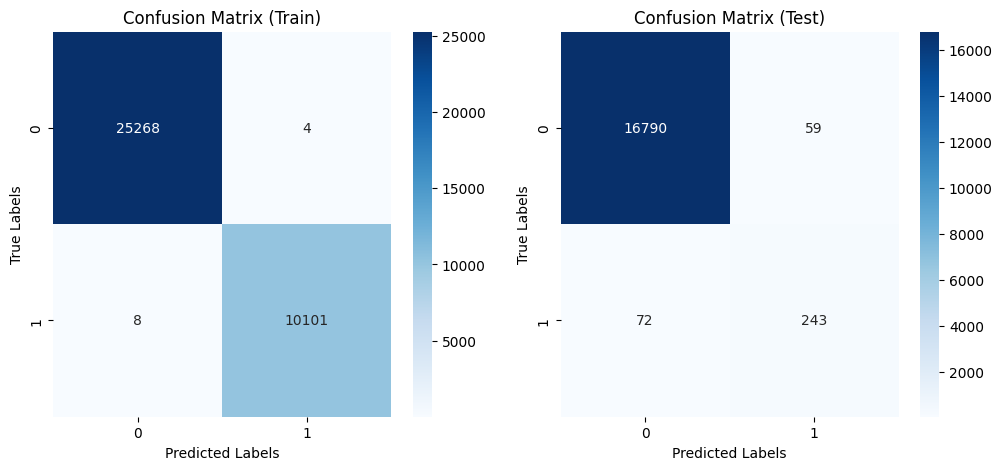

              Train      Test
Metric                       
Recall     0.999209  0.771429
AUC        0.999996  0.990119
Accuracy   0.999661  0.992368
Precision  0.999604  0.804636
F1 Score   0.999406  0.787682


In [ ]:
resultat_stacking = evaluate_tree_ensemble_model(best_stacking_model, X_train, y_train, X_valid, y_valid, y_train_proba, y_valid_proba, threshold=0.5)

## Model Prediction & Inference

In [40]:
# Make predictions on the test dataset
test_predictions = xgb_model.predict(test_df[features_for_modelling])
test_predictions_proba = xgb_model.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file

test_df['target'] = test_predictions
sub =  test_df[['ID', 'target']]
sub.head()


,ID,target
58082,ID_269404226088267278,0
58083,ID_255356300042267278,0
58084,ID_257026243764267278,0
58085,ID_264617299409267278,0
58086,ID_247613296713267278,0


In [41]:
sub.to_csv('/content/drive/MyDrive/hackaton/african_credit_scoring/submission_xgb_v3_0.csv', index=False)

#### To Do
* Handle imbalance
* Do more feature engineering
* Use more sophisticated machine learning algorithms
##### Good luck

train['target].value_counts()